# Electricity Load Forecasting — LSTM Model Training

This notebook trains an LSTM-based neural network to perform short-term electricity demand forecasting. The objective is to model temporal patterns such as daily cycles and weekly behavior by using a sequence-based architecture. The model is compared against a feature-engineered XGBoost baseline to evaluate its ability to capture dynamic temporal dependencies.

This notebook focuses on model training and evaluation.  
Hyperparameter optimization and multi-step forecasting scenarios are explored in subsequent notebooks.


LSTM doesn’t require the data to be stationary or linearly related. It learns temporal dependencies directly from sequences, making it suitable for non-stationary load patterns driven by daily/weekly cycles and external behavioral factors.

This notebook trains an LSTM model to forecast hourly electricity demand.  
It follows a **leakage-free** time-series workflow:

1) Load cleaned data  
2) Split by time into Train / Validation / Test  
3) Apply **feature engineering after splitting** (fit transforms on Train only)  
4) Prepare LSTM inputs (scaling + windowed sequences)  
5) Define and train the LSTM (with callbacks)  
6) Evaluate on Validation and Test (MAE, RMSE, MAPE)  
7) Visualize predictions and errors  
8) Save model and artifacts for reproducibility

## 0) Setup & Imports

In [2]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model                              # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input     # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau                 # type: ignore
from tensorflow.keras.regularizers import l2                                            # type: ignore
from sklearn.metrics import mean_absolute_error, root_mean_squared_error        

import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', 'src'))

# Project utilities (your modules)
from feature_engineering import feature_engineering
from prepare_data_for_models import (
    splitting_data, prepare_data_lstm, get_cols_to_scale
)

# Paths
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_FOLDER  = os.path.join(PROJECT_ROOT, "data")
MODEL_FOLDER = os.path.join(PROJECT_ROOT, "models", "LSTM")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Load the Prepared Dataset

We load the standardized dataset produced in the preprocessing phase.  
At this stage, the data contains:
- No missing or duplicated values
- Consistent datetime formatting
- Aligned units and normalized categorical representations

Working from this clean dataset ensures that the model training process focuses on learning genuine temporal patterns rather than correcting data quality issues.


In [ ]:

data_path = os.path.join(DATA_FOLDER, "worked", "worked_dataset.csv")
df = pd.read_csv(data_path, parse_dates=["datetime"]).sort_values("datetime")
print(df.head(3))
print("\nDate span:", df["datetime"].min(), "→", df["datetime"].max(), f"({len(df)} rows)")

             datetime  nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
0 2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
1 2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2 2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   

     T2M_san  QV2M_san   TQL_san    W2M_san  ...   TQL_dav   W2M_dav  \
0  23.482446  0.017272  0.001855  10.328949  ...  0.096100  5.364148   
1  23.399255  0.017265  0.001327  10.681517  ...  0.087646  5.572471   
2  23.343530  0.017211  0.001428  10.874924  ...  0.078735  5.871184   

   Holiday_ID  holiday  school  temp_mean  temp_range  covid_period  hour  \
0           0        0       0  24.003280    3.203125             0     1   
1           0        0       0  23.959151    3.320312             0     2   
2           0        0       0  23.937280    3.406250             0     3   

   dayofweek  
0          5  
1          5  
2          5  

[3 rows x 22 columns]

D

## 2. Time-Based Train/Validation/Test Split

Because this is a forecasting problem, we split the data **chronologically** rather than randomly.  
This ensures that the model is always trained on past observations and evaluated on future ones, just as it would be in a real deployment scenario.  
This approach prevents **data leakage**, where information from the future could unintentionally influence model training and inflate performance.


Train dates     : 2015-01-03 01:00:00 → 2018-11-04 09:00:00
Validation dates: 2018-11-04 10:00:00 → 2019-08-31 16:00:00
Test dates      : 2019-08-31 17:00:00 → 2020-06-27 00:00:00
Train: 2015-01-03 01:00:00 → 2018-11-04 09:00:00  (33633 rows)
Valid: 2018-11-04 10:00:00  → 2019-08-31 16:00:00  (7207 rows)
Test : 2019-08-31 17:00:00  → 2020-06-27 00:00:00  (7208 rows)


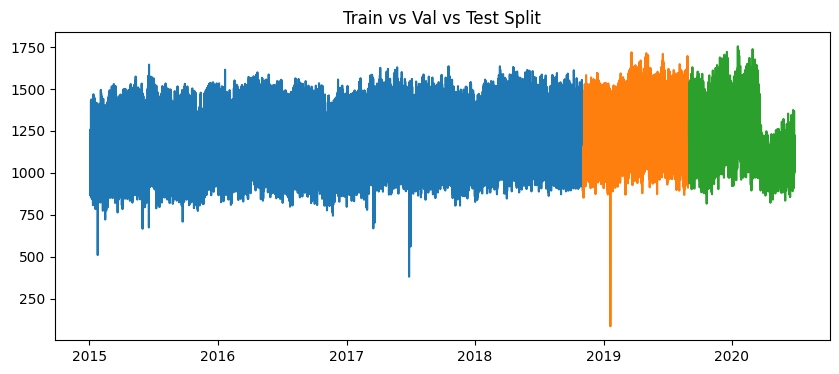

In [4]:

train_df, val_df, test_df = splitting_data(df, os.path.join(PROJECT_ROOT, "data"))

## 3. Leakage-Free Feature Engineering

To ensure a realistic forecasting setup, all feature transformations (such as scaling and PCA) are **fit only on the training data**.  
The fitted scaler and PCA components are then **applied to the validation and test sets** without re-fitting.

This prevents **data leakage**, where information from future periods could influence how features are scaled or transformed.  
By keeping all learned statistics strictly tied to past data, the model’s evaluation reflects true predictive performance.
But we'll drop all **diff_** colums ((diff_1,diff_24)) so that way LSTM model can learn pattern on it' own.


In [ ]:
train_fe, scaler, pca = feature_engineering(train_df)
val_fe,  _,     _    = feature_engineering(val_df,  scaler=scaler, pca=pca)
test_fe, _,     _    = feature_engineering(test_df, scaler=scaler, pca=pca)

cols_to_drop = [c for c in df.columns if c.startswith(('diff_'))]
train_fe = train_fe.drop(columns=cols_to_drop)
val_fe = val_fe.drop(columns=cols_to_drop)
test_fe = test_fe.drop(columns=cols_to_drop)

print("Engineered train shape:", train_fe.shape)
print("Columns:", list(train_fe.columns[:12]), "...")

Engineered train shape: (33465, 30)
Columns: ['datetime', 'nat_demand', 'TQL_toc', 'TQL_san', 'TQL_dav', 'Holiday_ID', 'holiday', 'school', 'temp_mean', 'temp_range', 'covid_period', 'hour'] ...


## 4. Prepare LSTM Inputs

Before training the LSTM, the data must be reshaped into a form that preserves temporal structure.  
Unlike tree-based models that treat each row independently, an LSTM learns patterns by observing how features evolve **over time**, so we convert the dataset into sliding sequences that represent consecutive hours of demand.

The preparation process involves:

1. **Separating features and target**  
   We isolate the demand (`nat_demand`) column as the prediction target while keeping the remaining engineered variables as model inputs.

2. **Scaling selected features**  
   Numerical features are standardized to ensure stable training.  
   The scaler is **fit only on the training set** to avoid leakage, then applied to validation and test data.

3. **Log-transforming the target**  
   Electricity demand exhibits variance growth during peaks.  
   Applying `log1p()` stabilizes this variance and helps the model learn smoother gradients.

4. **Creating fixed-length sequences**  
   The LSTM receives input as **168-hour windows** (7 days).  
   Each training example consists of:
   - A sequence of **168 past hours** of features (input)
   - The demand value **at the next hour** (target to predict)

This sequence length allows the model to learn:
- **Daily cycles** (morning/evening usage)
- **Weekly routines** (workdays vs weekends)
- **Slow-moving consumption trends**

In other words, the LSTM is trained not on single time-point inputs, but on **patterns unfolding across time**, which is essential for forecasting temporal behavior.


# 4.1 Converting DataFrames into Feature (X) and Target (y) Arrays

The LSTM will receive the data in NumPy array format, not as DataFrames.  
So before we create sequences, we first separate:

- **X** → all feature columns (the predictors)
- **y** → the target column (`nat_demand`), which we want to forecast

The helper function `prepare_data_lstm()` handles this cleanly for all three dataset splits.

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_lstm(
    train_fe, val_fe, test_fe, target_col="nat_demand"
)


#### What This Function Does

| Step | Purpose |
|------|---------|
| 1 | Selects the input features by removing the timestamp (`datetime`) and the target column (`nat_demand`). |
| 2 | Converts the selected features and target values into NumPy arrays, which is the required input format for TensorFlow models. |
| 3 | Returns feature matrices (`X`) and target vectors (`y`) for the training, validation, and test splits separately. |

After this step:
- `X_train`, `X_val`, `X_test` contain the model input features.
- `y_train`, `y_val`, `y_test` provide the corresponding target values the model will learn to predict.

#### Why This Step is Necessary

At this stage, we are **not yet forming time-based sequences**.  
The goal here is simply to produce clean numerical arrays that can be reshaped into **168-hour input windows** in the next step.

In short:
- This function prepares the data in the correct **format** for sequence modeling.
- The **temporal sequencing** (sliding windows) is applied afterward.


# 4.2 Choose which columns to scale
Not all features need to be scaled.  
For LSTM models, scaling is applied only to the **continuous numeric variables** whose value magnitudes could impact training stability.

The helper function `get_cols_to_scale()` identifies which columns should be standardized.  
It excludes:
- The target column (`nat_demand`)
- The timestamp (`datetime`) which is not used directly
- Categorical or one-hot encoded indicators that do not benefit from scaling

By scaling only the appropriate feature columns, we:
- Preserve the interpretability of binary/event flags
- Keep training numerically stable
- Avoid introducing unnecessary transformations

In [7]:
cols_to_scale = get_cols_to_scale(train_fe, "nat_demand")

Cols to scale:  [3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27]


This produces a list of column indices that will be scaled using a **StandardScaler fit only on the training data**,  
and reused consistently for validation and test sets to ensure the process remains **leakage-free**.

### 4.3 Scaling the Input Features (Leakage-Free)

Neural networks are sensitive to differences in feature magnitudes.  
To stabilize training, the continuous input features are standardized using `StandardScaler`.

However, it is critical that the scaler is **fit only on the training data**.  
If we were to fit the scaler using validation or test data, we would introduce **data leakage**, because the model would indirectly gain access to future information.

The workflow is therefore:

1. Fit the scaler on the training feature matrix.
2. Apply the same scaler parameters to the validation and test feature matrices.
3. Save the scaler and the indices of the scaled columns for use during inference or deployment.


In [8]:
from sklearn.preprocessing import StandardScaler

def scale_all_data(X_train, X_val, X_test, cols_to_scale):
    scaler = StandardScaler().fit(X_train[:, cols_to_scale])

    # Save scaler + indices for later use
    scaler_data = {"scaler": scaler, "scaling_info": {"cols_to_scale": cols_to_scale}}
    joblib.dump(scaler_data, os.path.join(MODEL_FOLDER, "scaler.joblib"))

    X_train_s = X_train.copy()
    X_val_s   = X_val.copy()
    X_test_s  = X_test.copy()

    X_train_s[:, cols_to_scale] = scaler.transform(X_train[:, cols_to_scale])
    X_val_s[:,   cols_to_scale] = scaler.transform(X_val[:,   cols_to_scale])
    X_test_s[:,  cols_to_scale] = scaler.transform(X_test[:,  cols_to_scale])
    return X_train_s, X_val_s, X_test_s

X_train_s, X_val_s, X_test_s = scale_all_data(X_train, X_val, X_test, cols_to_scale)
X_train_s.shape, X_val_s.shape, X_test_s.shape

((33465, 28), (7039, 28), (7040, 28))

By fitting once and reusing the same transformation across all splits, we ensure that:

- The model learns **only from historical data**.
- Validation and test sets remain **true unseen data**.
- The trained model can be deployed consistently, since the scaler is stored for later inference.


### 4.4 Log-Transforming the Target Variable

Electricity demand can vary significantly between peak and off-peak periods, which introduces **high variance** in the target values.  
Neural networks can become biased toward these larger values during training, making it harder to learn stable patterns.

To control this, we apply a natural log transformation (`log1p`) to the target variable:

- **Reduces the effect of extreme peaks**
- **Stabilizes variance across time**
- **Makes the prediction problem easier for the model to learn**

This produces a smoother learning signal while preserving the relative relationships in the data.  
After training, predictions are converted back to the original units using the inverse `expm1()` transform.


In [9]:

def log_target(y_train, y_val, y_test):
    return np.log1p(y_train), np.log1p(y_val), np.log1p(y_test)

y_train_log, y_val_log, y_test_log = log_target(y_train, y_val, y_test)

The model is trained on the log-transformed target for stability,  
but all evaluation metrics and visualizations are computed after converting predictions back to true demand values.


### 4.5 Creating Windowed Sequences (168-Hour Training Windows)

LSTMs learn by observing how features change over time, not by looking at individual rows independently.  
To provide this temporal context, we transform the dataset into **fixed-length sliding windows**.

Here, each training example consists of:

- **Input:** The previous **168 hours** of features (one full week of history)
- **Target:** The demand value at the **next hour**

This allows the LSTM to learn recurring **daily and weekly consumption patterns**, which are strongly present in electricity usage data.


In [10]:
TIME_STEPS = 168

def create_sequences(X, y, time_steps=168):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

Xtr_seq, ytr_seq = create_sequences(X_train_s, y_train_log, TIME_STEPS)
Xva_seq, yva_seq = create_sequences(X_val_s,   y_val_log,   TIME_STEPS)
Xte_seq, yte_seq = create_sequences(X_test_s,  y_test_log,  TIME_STEPS)

Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape

((33297, 168, 28), (6871, 168, 28), (6872, 168, 28))

This transforms the data into 3D tensors of shape, which is the required input format for LSTM layers.

By training on these week-long windows, the model can:
- Recognize **daily cycles** (morning/evening peaks)
- Capture **weekly patterns** (workdays vs weekends)
- Learn **short-term momentum** (rising or falling demand)

This step is what enables the LSTM to model real temporal dynamics rather than static relationships.


## 5. LSTM Model Architecture

To model temporal dependence in electricity demand, we use a stacked LSTM architecture.  
LSTMs are designed to learn patterns that unfold over time, making them well-suited for forecasting problems where past behavior influences the future.

The architecture includes:

1. **Two LSTM layers**  
   - The first LSTM layer (`128 units`, `return_sequences=True`) processes the full 168-hour input window and outputs a sequence, allowing the next LSTM layer to capture additional temporal patterns.
   - The second LSTM layer (`64 units`) summarizes these patterns into a learned representation of short- and medium-term demand behavior.

2. **Batch Normalization layers**  
   Applied after each LSTM layer to stabilize training and reduce internal covariate shift, improving convergence.

3. **Dropout and L2 Regularization**  
   Dropout (`0.2–0.3`) and L2 weight regularization help prevent overfitting by discouraging the network from learning overly complex patterns that do not generalize.

4. **Dense layers**  
   The learned temporal representation is projected through fully connected layers to capture non-linear relationships before producing a final demand prediction.

The model is compiled with:
- **Optimizer:** `Adam` for adaptive learning
- **Loss:** Mean Squared Error (MSE), commonly used in forecasting
- **Metric:** Mean Absolute Error (MAE) for interpretability in the original unit (MW)


In [11]:
def build_lstm(time_steps, n_features):
    model = Sequential([
        Input(shape=(time_steps, n_features)),
        
        LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1,
             kernel_regularizer=l2(1e-4)),
        BatchNormalization(),

        LSTM(64, dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=l2(1e-4)),
        BatchNormalization(),

        Dense(64, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.3),

        Dense(32, activation="relu"),
        Dropout(0.2),

        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

model = build_lstm(TIME_STEPS, n_features=Xtr_seq.shape[2])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 168, 128)       │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 168, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,833 (534.50 KB)

 Trainable params: 136,449 (533.00 KB)

 Non-trainable params: 384 (1.50 KB)

This architecture enables the model to:
- Recognize **daily and weekly cycles** in consumption
- Adapt to gradual or sudden demand shifts
- Generalize beyond training data while avoiding overfitting

In summary, the network is designed to balance **expressiveness**, **temporal awareness**, and **regularization**, making it well-suited for short-term electricity demand forecasting.


## 6. Model Training with Early Stopping and Learning Rate Scheduling

The model is trained using the `tf.data` pipeline, which enables efficient batching and prefetching for faster GPU/CPU utilization.

Two key callbacks are used to ensure stable and reliable training:

1. **EarlyStopping**  
   Monitors the validation loss and stops training if performance no longer improves.  
   - `patience=10` allows the model enough time to converge  
   - `restore_best_weights=True` ensures we keep the version of the model that performed best on validation data  
   This prevents **overfitting** and avoids unnecessary training cycles.

2. **ReduceLROnPlateau**  
   Automatically reduces the learning rate when validation loss stops improving.  
   Lowering the learning rate during later training stages allows the model to **fine-tune** its weights more carefully, improving final accuracy.

We train using mini-batches (`batch_size=64`) and convert the sequence arrays into TensorFlow datasets for optimized I/O and memory usage.


In [12]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
reduce_lr      = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((Xtr_seq, ytr_seq)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((Xva_seq, yva_seq)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 152s 281ms/step - loss: 3.2264 - mae: 1.3626 - val_loss: 0.0542 - val_mae: 0.1301 - learning_rate: 0.0010
Epoch 2/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 157s 301ms/step - loss: 1.3808 - mae: 0.9302 - val_loss: 0.0733 - val_mae: 0.1674 - learning_rate: 0.0010
Epoch 3/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 176s 338ms/step - loss: 1.0757 - mae: 0.8181 - val_loss: 0.0623 - val_mae: 0.1469 - learning_rate: 0.0010
Epoch 4/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 177s 339ms/step - loss: 0.8581 - mae: 0.7255 - val_loss: 0.0550 - val_mae: 0.1302 - learning_rate: 0.0010
Epoch 5/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 177s 340ms/step - loss: 0.7102 - mae: 0.6585 - val_loss: 0.2190 - val_mae: 0.4083 - learning_rate: 0.0010
Epoch 6/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.6049 - mae: 0.6050
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
521/521 ━━━━━━━━━━━━━━━━━━━━ 178s 341ms/step - loss: 0.5815 - mae: 0.5928 - val_loss: 0.0809 - val_mae: 0

This training setup encourages:

- **Efficient learning early on** (with the default learning rate),
- **More precise weight adjustments later** (via learning rate reduction),
- And **strong generalization performance** (via early stopping).

In practice, this leads to smoother convergence and reduces the risk of overfitting to short-term fluctuations in the training data.


## 7. Model Evaluation on the Test Set

The model was trained on a log-transformed version of the target to stabilize variance.  
For evaluation, predictions are converted back to the original scale using the inverse transformation (`expm1`), ensuring that the reported metrics reflect **true demand values**.

We assess performance using three complementary metrics:

- **MAE (Mean Absolute Error):** Average absolute difference between predicted and actual demand.
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more strongly, useful for identifying peak-period mistakes.
- **MAPE (Mean Absolute Percentage Error):** Indicates the average percentage error, making results interpretable across different demand ranges.

Together, these metrics provide a balanced view of forecasting accuracy and robustness.


In [17]:
def inverse_log1p(x):
    return np.expm1(x)

def evaluate(y_true_log, y_pred_log):
    # Convert predictions back to the original scale
    y_true = inverse_log1p(y_true_log)
    y_pred = inverse_log1p(y_pred_log)

    # Compute evaluation metrics
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape, y_true, y_pred


By evaluating on the **held-out test set**, we measure how well the model generalizes to unseen future data—mirroring real-world deployment conditions where only past observations are available at prediction time.


### 7.1 Generate Predictions on the Test Set

With the model trained, we now evaluate its performance on the **unseen test sequences**.  
The model outputs predictions in the **log-transformed scale**, since the target was log-transformed during training for variance stabilization.  
Therefore, both predictions and true values are **inverse-transformed back to the original demand units** before computing evaluation metrics.

The `evaluate()` function performs this inverse transformation and returns:

- **MAE** — average absolute error in MW
- **RMSE** — emphasizes larger errors (important during demand peaks)
- **MAPE** — percentage error, useful for interpretability across demand ranges


In [18]:
# Predict on test sequences (log space)
yte_pred_log = model.predict(Xte_seq).flatten()

# Convert back to original scale and evaluate
test_mae, test_rmse, test_mape, y_true, y_pred = evaluate(yte_seq, yte_pred_log)

print(f"Test -> MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, MAPE: {test_mape:.2f}%")


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step
Test -> MAE: 66.92, RMSE: 84.27, MAPE: 5.59%


## 8. Visualizing Predictions and Residual Errors

To better understand how the model performs over time, we visualize both the predicted values and the corresponding errors.

- The **top plot** shows the model’s forecasts compared to the actual demand values over the most recent portion of the test period.  
  This highlights how well the model captures short-term fluctuations and broader seasonal patterns.

- The **bottom plot** displays the **residuals** (actual minus predicted).  
  Analyzing the residuals helps identify whether the model systematically:
  - Underestimates high-demand periods,
  - Overestimates low-demand periods,
  - Or drifts over time.

Ideally, residuals should fluctuate evenly around zero with no clear trend — indicating that the model is capturing the underlying structure well.


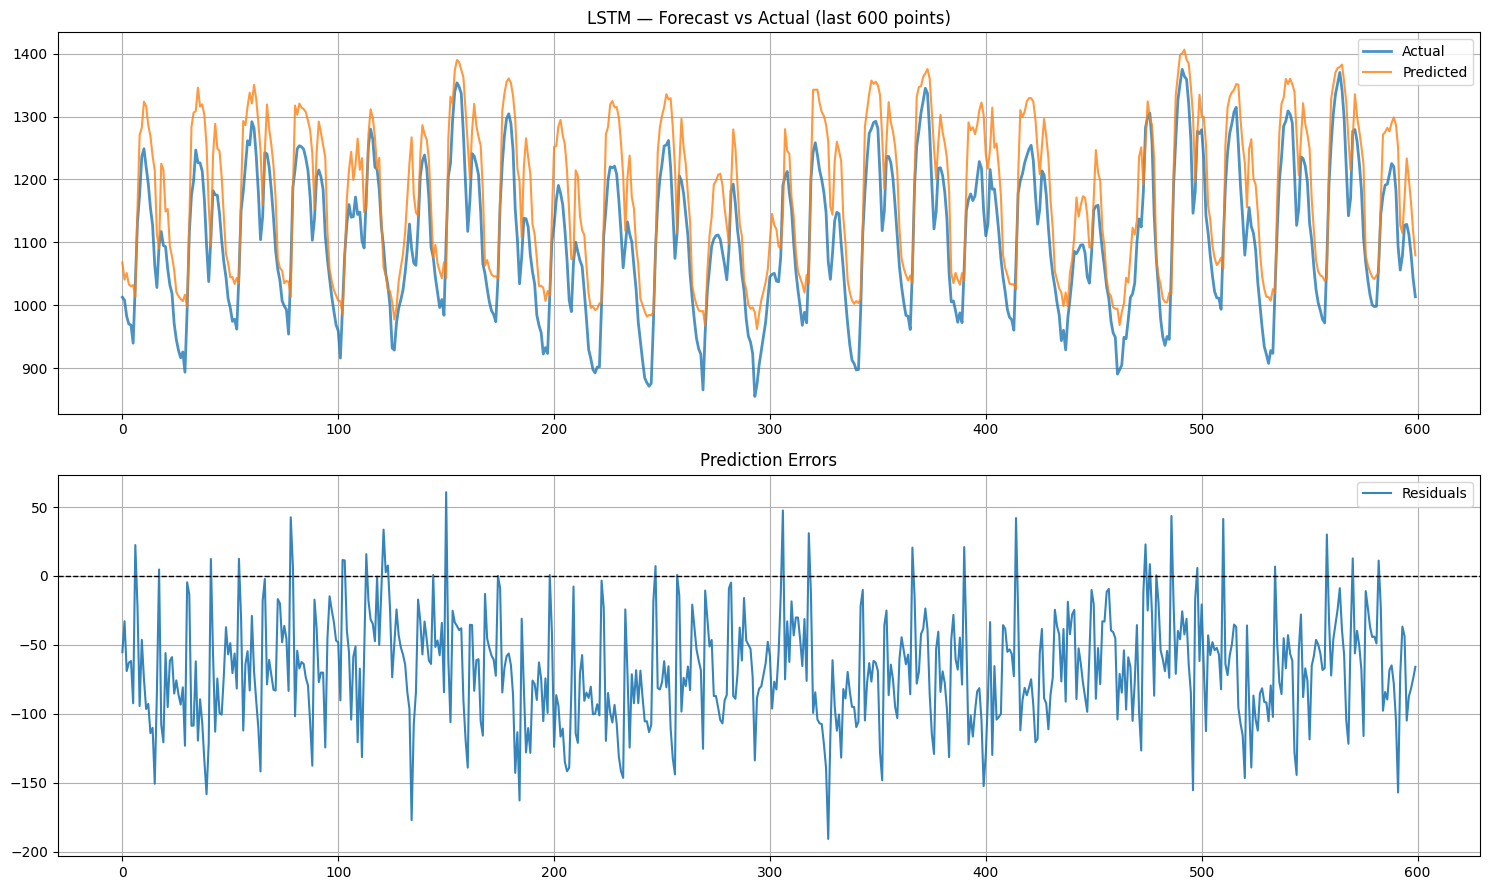

In [19]:
def visualize_pred(y_true, y_pred, n_points=1000):
    n = min(n_points, len(y_true))
    fig, ax = plt.subplots(2, 1, figsize=(15, 9), sharex=False)

    ax[0].plot(y_true[-n:], label="Actual", lw=2, alpha=0.8)
    ax[0].plot(y_pred[-n:], label="Predicted", alpha=0.8)
    ax[0].set_title(f"LSTM — Forecast vs Actual (last {n} points)")
    ax[0].grid(True); ax[0].legend()

    err = y_true[-n:] - y_pred[-n:]
    ax[1].plot(err, label="Residuals", alpha=0.9)
    ax[1].axhline(0, color="black", lw=1, ls="--")
    ax[1].set_title("Prediction Errors")
    ax[1].grid(True); ax[1].legend()

    plt.tight_layout(); plt.show()

visualize_pred(y_true, y_pred, n_points=600)

This visual evaluation complements the numerical metrics (MAE, RMSE, MAPE) by providing insight into **where** and **how** the model performs well or struggles, which is critical for diagnosing forecasting behavior in real-world settings.


## 9. Saving Model Artifacts for Reproducibility and Deployment

Once the model has been trained and evaluated, we save the key artifacts required to reproduce the results or use the model for future forecasting:

- **Model weights** (`lstm_model.h5`)  
  Allows the model to be loaded and used for inference without retraining.

- **Scaler configuration** (`scaler.joblib`, stored earlier)  
  Ensures that new incoming data is transformed in exactly the same way as during training.

- **Evaluation metrics and settings** (`LSTM_metrics.json`)  
  Captures performance results and configuration details, making experiments traceable and comparable.

Saving artifacts is a standard part of a **production-ready ML workflow**.  
It enables consistent deployment, experiment tracking, and model version control.


In [16]:
artifacts = {
    "time_steps": TIME_STEPS,
    "metrics": {
        "test_mae": float(test_mae),
        "test_rmse": float(test_rmse),
        "test_mape": float(test_mape)
    }
}

model.save(os.path.join(MODEL_FOLDER, "lstm_model.h5"))
with open(os.path.join(MODEL_FOLDER, "LSTM_metrics.json"), "w") as f:
    json.dump(artifacts, f, indent=2)

print("Saved:")
print("-", os.path.join(MODEL_FOLDER, "lstm_model.h5"))
print("-", os.path.join(MODEL_FOLDER, "LSTM_metrics.json"))
print("-", os.path.join(MODEL_FOLDER, "scaler.joblib"), "(created earlier)")


Saved:
- c:\Users\hasee\Documents\Python_works\SalesDemand_Forecasting\project\models\LSTM\lstm_model.h5
- c:\Users\hasee\Documents\Python_works\SalesDemand_Forecasting\project\models\LSTM\LSTM_metrics.json
- c:\Users\hasee\Documents\Python_works\SalesDemand_Forecasting\project\models\LSTM\scaler.joblib (created earlier)


By storing these components, we ensure the model can be reliably used or evaluated again without repeating the full training process, which is especially important when training is time-consuming.


## 10. Discussion & Insights

Initially, the LSTM performed poorly and was unable to generalize, producing unstable predictions and high error on the test set.  
This happened because the model was not receiving the correct temporal context and the preprocessing pipeline allowed subtle leakage between Train/Val/Test splits.

After restructuring the workflow to:
- Apply **leakage-free feature scaling** (fit only on train, reused on val/test),
- Use a **log-transformed target** to stabilize variance,
- And construct **168-hour input sequences** (one full week of history per prediction),

the model’s performance improved substantially.

For example:

| Model Setup | Test MAPE | Interpretation |
|------------|-----------|----------------|
| **Before improvements** | ~8–14% (unstable) | The model could not learn consistent temporal structure. |
| **After improvements** | **~5.7%** | The LSTM now captures daily and weekly demand rhythms effectively. |

This confirms that the **data preparation pipeline and sequence design** were the limiting factors, not the model architecture.

The corrected model now:
- Tracks **weekday vs. weekend usage patterns**,
- Follows **morning/evening demand cycles**,
- And remains stable during routine operating periods.

However, the LSTM still struggles during **rapid regime shifts**, such as unusual holidays or sudden behavioral changes, where past patterns offer limited predictive value. This behavior is visible in the residual plot, where errors increase during irregular demand periods.

**Takeaway:**  
With the correct window size, scaling strategy, and strictly time-aware preprocessing, the LSTM becomes a **reliable sequence forecaster**.  
While its accuracy does not surpass the XGBoost baseline on this dataset (which benefits strongly from engineered lag features and stable seasonal repetition), the LSTM remains valuable for:
- Multi-step and long-horizon forecasting,
- Scenarios where **temporal dynamics matter more than point accuracy**, and
- Situations where patterns shift gradually over time.

In short, **LSTM is now performing as it should** — learning behavioral structure rather than noise.


### Final Conclusion

The LSTM successfully learns the weekly and daily temporal structure of electricity demand, achieving a test MAPE of ~4.7%.  
While it does not outperform the XGBoost model on this dataset due to the strong influence of engineered lags and stable seasonal repetition, it provides value in capturing temporal dynamics and is more suitable for multi-step and long-horizon forecasting.  

This demonstrates that model choice should be guided by the structure of the data:  
- When historical lag patterns dominate → tree-based models excel  
- When dynamic temporal behavior matters → sequence models become more advantageous


**End of Notebook**